In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Add, InputLayer, Dropout
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
path = 'CSV_Data'
train_folder = 'Train'
test_folder = 'Test'
file = 'all_poses.csv'

train_path = os.path.join(path, train_folder, file)
test_path = os.path.join(path, test_folder, file)
data_path = os.path.join(path, file)

all_data = pd.read_csv(data_path)
all_data = all_data[all_data.pose != 'squats_up']
all_data = all_data[all_data.pose != 'pullups_up']
all_data

,image,pose,x_left_shoulder_left_wrist,y_left_shoulder_left_wrist,z_left_shoulder_left_wrist,x_right_shoulder_right_wrist,y_right_shoulder_right_wrist,z_right_shoulder_right_wrist,x_left_hip_left_ankle,y_left_hip_left_ankle,...,left_shoulder_left_ankle,right_shoulder_right_ankle,left_hip_right_wrist,right_hip_left_wrist,left_elbow_right_elbow,left_knee_right_knee,left_wrist_right_wrist,left_ankle_right_ankle,left_hip_avg_left_wrist_left_ankle,right_hip_avg_right_wrist_right_ankle
0,E.jpg,jumping_jacks_down,2.639651,36.533203,11.606357,-2.096311,39.660770,3.333271,0.709485,34.756783,...,107.80279,101.256220,25.964552,20.129477,21.891373,9.572068,23.628513,8.817467,24.935423,21.897507
1,JJ.00_00_00_21.Still610.jpg,jumping_jacks_down,5.621649,58.556816,-29.103119,-9.555062,60.220802,-24.859550,-1.686714,52.419790,...,108.05316,108.368080,99.120370,111.111630,34.513107,13.026263,39.510204,10.478581,70.999214,66.304980
2,JJ.00_00_02_12.Still611.jpg,jumping_jacks_down,8.570704,61.962692,-30.658058,-11.030880,60.725990,-31.648384,-2.288830,49.784800,...,103.96043,102.363594,109.834720,115.859040,37.486490,14.406796,43.056570,9.337358,75.719420,73.916530
3,JJ.00_00_04_00.Still612.jpg,jumping_jacks_down,12.450983,46.677666,-20.392890,-16.460460,50.275375,-17.970360,-2.673132,57.219868,...,119.82603,118.113594,92.485230,105.289980,38.071854,12.797712,50.756527,9.881827,60.924847,59.798840
4,JJ.00_00_07_11.Still614.jpg,jumping_jacks_down,9.353104,27.570175,-10.257456,-8.173931,27.220562,-33.421550,-1.316952,49.857510,...,105.16242,102.763930,44.958740,31.483402,22.992490,6.848766,36.983727,5.223047,23.287280,19.660568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,Squat.00_01_57_00.Still504.jpg,squats_down,-23.597694,-5.511532,-7.457489,-21.436480,-3.342987,-10.796139,-11.009216,29.468292,...,82.11504,68.763450,57.913616,75.247284,58.881910,42.237495,42.752155,54.325190,25.789604,26.943950
1028,Squat.00_01_58_19.Still505.jpg,squats_down,-26.597020,-3.168335,-16.090850,-23.660694,-2.230591,-12.611333,-13.492986,40.809350,...,90.63101,81.952860,59.481926,91.066670,71.700550,40.561620,55.602177,40.773790,28.352434,25.849234
1029,Squat.00_02_06_23.Still508.jpg,squats_down,-2.706154,8.250389,16.541473,-22.057590,1.867138,-4.232449,8.859005,35.418730,...,72.36273,74.433716,62.016724,52.953926,55.576970,46.095230,62.543820,30.127186,8.839324,13.560546
1030,Squat.00_02_13_11.Still509.jpg,squats_down,-8.479526,1.641724,39.643078,-11.209259,1.283150,45.824978,-4.686064,41.742065,...,83.38031,86.537350,99.474580,56.236942,43.171886,36.541058,36.069680,26.892101,29.037422,34.199080


In [3]:
labels = all_data.iloc[:, [1]]
features = all_data.iloc[:, 2:-16]

data = [labels, features]
data = pd.concat(data, axis=1)

class_names = np.unique(labels[labels.columns].values)
class_counts = labels[labels.columns].value_counts()
labels[labels.columns] =  labels[labels.columns].apply(LabelEncoder().fit_transform)

data[labels.columns] =  data[labels.columns].apply(LabelEncoder().fit_transform)

len(data.columns)

/var/folders/vg/t3b5blds61gg_g1ctjjh7lg80000gn/T/ipykernel_8629/2304533209.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[labels.columns] =  labels[labels.columns].apply(LabelEncoder().fit_transform)


56

In [6]:
X_train, X_, y_train, y_ = train_test_split(features, labels, test_size = 0.40, random_state = 2, stratify = labels)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size = 0.50, random_state = 2, stratify = y_)#

Metal device set to: Apple M1


2022-11-09 21:19:38.567824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-09 21:19:38.568609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


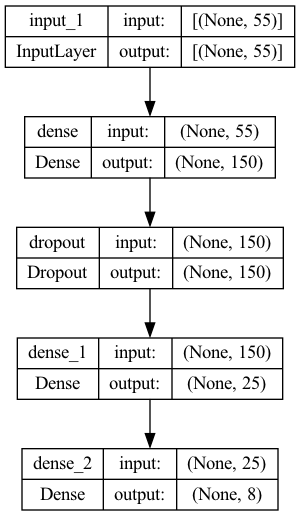

In [7]:
input_distance = Input(shape=(55))
dense_distance0 = Dense(150, activation='relu')(input_distance)
dropout0 = Dropout(0.4)(dense_distance0)

dense2 = Dense(25, activation='relu')(dropout0)
dropout2 = Dropout(0.4)(dense2)

output = Dense(8, activation='softmax')(dense2)



model = Model(inputs=[input_distance], outputs=output)

# summary
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


In [8]:
model.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])


In [10]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
    patience=15, 
    min_delta=0.001, 
    mode='max')
his = model.fit(X_train, y_train, 
        epochs=300, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
#X_train.iloc[:,-7:],
 

Epoch 1/300


2022-11-09 21:19:39.519362: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-09 21:19:39.895775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 4s 36ms/step - loss: 22.9754 - accuracy: 0.2937 - val_loss: 4.5272 - val_accuracy: 0.5833
Epoch 2/300
 8/17 [=============>................] - ETA: 0s - loss: 8.5112 - accuracy: 0.5000 

2022-11-09 21:19:43.656098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 10ms/step - loss: 7.8836 - accuracy: 0.4926 - val_loss: 3.5455 - val_accuracy: 0.6389
Epoch 3/300
17/17 [==============================] - 0s 9ms/step - loss: 5.2425 - accuracy: 0.5874 - val_loss: 1.6850 - val_accuracy: 0.7111
Epoch 4/300
17/17 [==============================] - 0s 10ms/step - loss: 3.5473 - accuracy: 0.6413 - val_loss: 1.8567 - val_accuracy: 0.6722
Epoch 5/300
17/17 [==============================] - 0s 10ms/step - loss: 2.5854 - accuracy: 0.6245 - val_loss: 1.2256 - val_accuracy: 0.7389
Epoch 6/300
17/17 [==============================] - 0s 10ms/step - loss: 2.2532 - accuracy: 0.6840 - val_loss: 1.2477 - val_accuracy: 0.7444
Epoch 7/300
17/17 [==============================] - 0s 9ms/step - loss: 1.7386 - accuracy: 0.7286 - val_loss: 1.1260 - val_accuracy: 0.7556
Epoch 8/300
17/17 [==============================] - 0s 10ms/step - loss: 1.7762 - accuracy: 0.7045 - val_loss: 1.0635 - val_accuracy: 0.7500
Epoch 9/300
17/17 [=

17/17 [==============================] - 0s 9ms/step - loss: 0.2416 - accuracy: 0.9089 - val_loss: 0.5876 - val_accuracy: 0.8611
Epoch 60/300
17/17 [==============================] - 0s 9ms/step - loss: 0.1868 - accuracy: 0.9349 - val_loss: 0.5684 - val_accuracy: 0.8611
Epoch 61/300
17/17 [==============================] - 0s 9ms/step - loss: 0.1763 - accuracy: 0.9257 - val_loss: 0.6048 - val_accuracy: 0.8667


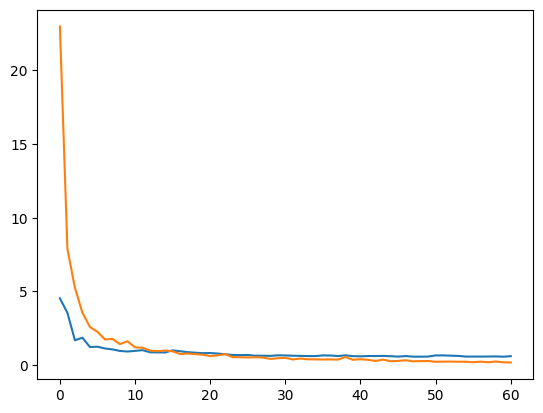

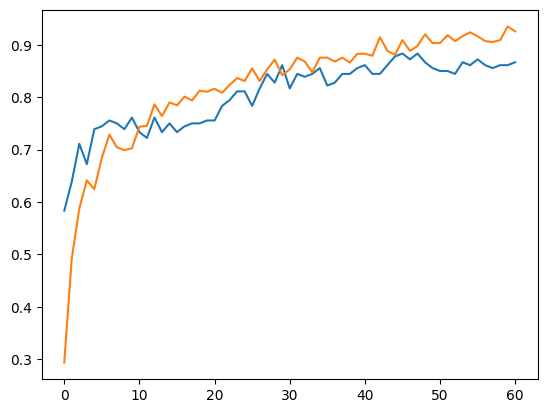

In [11]:
plt.figure()
plt.plot(his.history['val_loss'])
plt.plot(his.history['loss'])

plt.figure()
plt.plot(his.history['val_accuracy'])
plt.plot(his.history['accuracy'])

In [12]:
test_loss, test_acc = model.evaluate([X_test], y_test,
                                   batch_size=32,
                                   verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Test loss: 0.4328034222126007
Test accuracy: 0.8770950436592102


2022-11-09 21:20:06.058796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [28]:
prob = model.predict(X_test)
predictions = np.argmax (prob, axis = 1)

8/8 [==============================] - 0s 4ms/step


2022-11-09 21:06:12.744347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [29]:
predictions

array([5, 4, 6, 5, 5, 0, 0, 5, 0, 3, 3, 1, 3, 3, 6, 1, 5, 0, 4, 0, 4, 1,
       0, 2, 4, 0, 0, 1, 5, 1, 5, 0, 6, 2, 2, 1, 1, 5, 3, 0, 7, 3, 7, 2,
       5, 6, 2, 0, 7, 4, 6, 5, 0, 0, 7, 2, 7, 7, 2, 6, 6, 2, 0, 1, 1, 3,
       0, 5, 1, 1, 1, 0, 6, 1, 0, 3, 4, 2, 1, 7, 2, 7, 0, 5, 4, 6, 3, 0,
       5, 5, 0, 5, 6, 6, 6, 5, 1, 7, 7, 0, 4, 2, 7, 2, 7, 3, 4, 1, 0, 7,
       5, 5, 2, 5, 0, 2, 2, 6, 3, 7, 0, 1, 2, 0, 2, 3, 0, 1, 0, 0, 4, 0,
       2, 1, 6, 6, 1, 1, 7, 3, 1, 0, 7, 7, 0, 0, 5, 3, 3, 0, 7, 5, 6, 1,
       0, 1, 6, 3, 6, 2, 3, 4, 7, 4, 7, 2, 1, 4, 0, 0, 6, 5, 1, 4, 3, 2,
       4, 3, 3, 1, 2, 4, 5, 3, 7, 1, 4, 3, 1, 6, 7, 1, 4, 2, 2, 5, 0, 7,
       7, 4, 1, 6, 3, 7, 2, 7, 0, 0, 4, 2, 3, 6, 2, 1, 6, 1, 3, 0, 7, 5,
       5, 7, 0, 0, 0, 4, 4, 2, 0, 3, 0, 2, 5, 6])

In [30]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy on test: ", accuracy)

Accuracy on test:  0.8333333333333334


In [31]:
confusion_matrix(y_test, predictions)

array([[37,  0,  0,  1,  0,  0,  0,  0],
       [ 0, 30,  1,  0,  0,  0,  1,  4],
       [ 0,  2, 26,  0,  1,  1,  1,  0],
       [ 2,  1,  1, 19,  0,  1,  0,  3],
       [ 0,  0,  0,  2, 19,  0,  0,  0],
       [ 0,  0,  0,  2,  2, 24,  0,  1],
       [ 1,  0,  0,  0,  0,  0, 22,  2],
       [ 5,  0,  1,  2,  0,  1,  0, 18]])

In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89        38
           1       0.91      0.83      0.87        36
           2       0.90      0.84      0.87        31
           3       0.73      0.70      0.72        27
           4       0.86      0.90      0.88        21
           5       0.89      0.83      0.86        29
           6       0.92      0.88      0.90        25
           7       0.64      0.67      0.65        27

    accuracy                           0.83       234
   macro avg       0.83      0.83      0.83       234
weighted avg       0.84      0.83      0.83       234



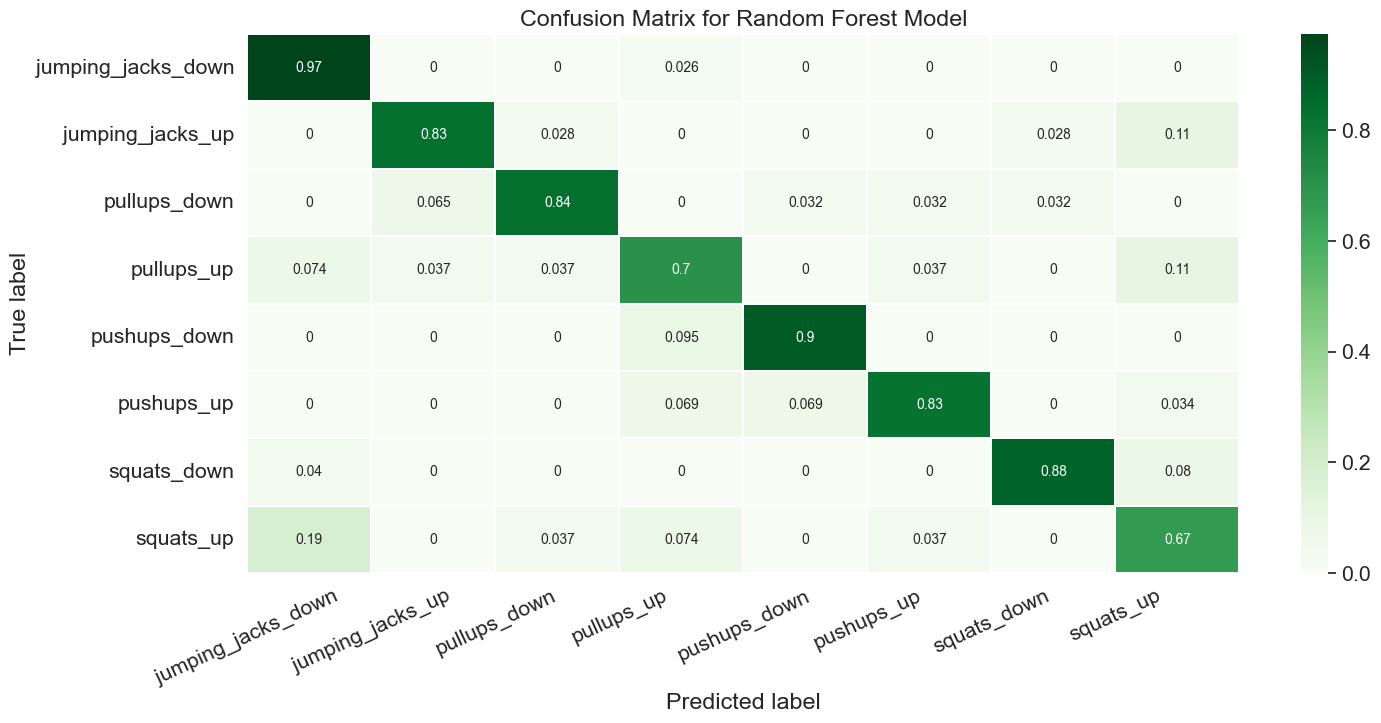

In [33]:
matrix = confusion_matrix(y_test, predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sb.set(font_scale=1.4)
sb.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


In [8]:
class_counts

pose              
jumping_jacks_down    189
jumping_jacks_up      181
pullups_down          154
pushups_up            144
squats_down           127
pushups_down          102
dtype: int64

In [ ]:
data = {'Actual': y_test.values.ravel(),
        'Predicted': predictions}
  
# Create DataFrame
df = pd.DataFrame(data)